Importando bibliotecas necessárias para o desenvolvimento

In [212]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import openai
from keys import openai_key, nasa_key

Criando variáveis e consumindo a API da Nasa

In [213]:
nasa_key = nasa_key


base_url = 'https://api.nasa.gov/neo/rest/v1/feed'


start_date = (datetime.now() - timedelta(days=7)).strftime('%Y-%m-%d')
end_date = datetime.now().strftime('%Y-%m-%d')

params = {
    'start_date': start_date,
    'end_date': end_date,
    'api_key': nasa_key
}

response = requests.get(base_url, params=params)
data = response.json()

Configurando a Gen AI do OpenAI

In [214]:
openai.api_key = openai_key
headers = {'Authorization': f'Bearer {openai_key}', 'Content-Type': 'application/json'}
link = 'https://api.openai.com/v1/chat/completions'
id_model = 'gpt-4o'

def get_ai_response(prompt):
    body_message = {
        'model': id_model,
        'messages': [{'role': 'user', 'content': prompt}]
    }

    response_ai = requests.post(link, headers=headers, json=body_message)  # Use json= para enviar o corpo como JSON
    return response_ai.json()

Tratando a api e gerando uma lista com os dados que foram selecionados

In [215]:
asteroids = []
for date, asteroids_list in data['near_earth_objects'].items():
    for asteroid in asteroids_list:
        asteroids.append({
            'name': asteroid['name'],
            'close_approach_date': date,
            'velocity_kmh': asteroid['close_approach_data'][0]['relative_velocity']['kilometers_per_hour'],
            'estimated_diameter_min': asteroid['estimated_diameter']['meters']['estimated_diameter_min'],
            'estimated_diameter_max': asteroid['estimated_diameter']['meters']['estimated_diameter_max'],
            "miss_distance_km": asteroid['close_approach_data'][0]['miss_distance']['kilometers'],
            'is_potentially_hazardous': asteroid['is_potentially_hazardous_asteroid']
        })

Criando o DataFrame a partir da lista 'asteroids'

In [216]:
df_asteroids = pd.DataFrame(asteroids)

Visualizando as primeiras linhas

In [217]:
df_asteroids.head()

,name,close_approach_date,velocity_kmh,estimated_diameter_min,estimated_diameter_max,miss_distance_km,is_potentially_hazardous
0,412977 (1990 UO),2024-10-20,148185.7480262956,324.007435,724.502651,69887104.254764291,False
1,495615 (2015 PQ291),2024-10-20,82317.0440716297,766.575574,1714.115092,52394019.758446318,False
2,526742 (2006 WR127),2024-10-20,53453.4606550249,212.106988,474.285643,41208195.072126918,False
3,(2014 US115),2024-10-20,68985.4822516714,31.956189,71.456210,57336403.669540838,False
4,(2015 KG19),2024-10-20,27404.305513672,55.789822,124.749835,33890943.164648171,False


Criando o diametro estimado médio para cada asteroide

In [218]:
df_asteroids['estimated_diameter_mean'] = (df_asteroids['estimated_diameter_max'] + df_asteroids['estimated_diameter_min']) / 2

In [219]:
df_asteroids

,name,close_approach_date,velocity_kmh,estimated_diameter_min,estimated_diameter_max,miss_distance_km,is_potentially_hazardous,estimated_diameter_mean
0,412977 (1990 UO),2024-10-20,148185.7480262956,324.007435,724.502651,69887104.254764291,False,524.255043
1,495615 (2015 PQ291),2024-10-20,82317.0440716297,766.575574,1714.115092,52394019.758446318,False,1240.345333
2,526742 (2006 WR127),2024-10-20,53453.4606550249,212.106988,474.285643,41208195.072126918,False,343.196316
3,(2014 US115),2024-10-20,68985.4822516714,31.956189,71.456210,57336403.669540838,False,51.706199
4,(2015 KG19),2024-10-20,27404.305513672,55.789822,124.749835,33890943.164648171,False,90.269828
...,...,...,...,...,...,...,...,...
149,(2024 TQ3),2024-10-22,30556.439124071,56.306039,125.904131,24102959.659147515,False,91.105085
150,(2024 UL),2024-10-22,45176.9657045404,58.499880,130.809709,12790801.456546277,False,94.654794
151,(2024 UR),2024-10-22,58739.0993249447,36.354232,81.290534,2109018.399516151,False,58.822383
152,(2024 US),2024-10-22,28169.6271792723,6.744581,15.081342,362447.96340405,False,10.912961


Visualizando informações sobre o DataFrame, como o tipo de dado de cada coluna

In [220]:
df_asteroids.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   name                      154 non-null    object 
 1   close_approach_date       154 non-null    object 
 2   velocity_kmh              154 non-null    object 
 3   estimated_diameter_min    154 non-null    float64
 4   estimated_diameter_max    154 non-null    float64
 5   miss_distance_km          154 non-null    object 
 6   is_potentially_hazardous  154 non-null    bool   
 7   estimated_diameter_mean   154 non-null    float64
dtypes: bool(1), float64(3), object(4)
memory usage: 8.7+ KB


Ajustando o tipo de dados para as colunas necessárias

In [221]:
df_asteroids['close_approach_date'] = pd.to_datetime(df_asteroids['close_approach_date'])

df_asteroids['miss_distance_km'] = df_asteroids['miss_distance_km'].astype('float64')

df_asteroids['velocity_kmh'] = df_asteroids['velocity_kmh'].astype('float64')

Descrição estatítisca dos dados das colunas de data e numéricas

In [222]:
df_asteroids.describe()

,close_approach_date,velocity_kmh,estimated_diameter_min,estimated_diameter_max,miss_distance_km,estimated_diameter_mean
count,154,154.000000,154.000000,154.000000,1.540000e+02,154.000000
mean,2024-10-22 03:44:24.935064832,44937.962640,93.953946,210.087411,3.245644e+07,152.020679
min,2024-10-19 00:00:00,4966.978391,2.731209,6.107170,4.636481e+04,4.419189
25%,2024-10-20 00:00:00,28716.141426,18.434951,41.221803,1.289759e+07,29.828377
50%,2024-10-22 00:00:00,42411.983556,39.680158,88.727532,3.061123e+07,64.203845
75%,2024-10-24 00:00:00,55778.474189,94.635883,211.612268,5.273305e+07,153.124076
max,2024-10-26 00:00:00,148185.748026,996.678240,2228.640296,7.363303e+07,1612.659268
std,NaN,22935.845485,154.941919,346.460665,2.303389e+07,250.701292


### Primeira Análise - Número de Asteróides que passaram próximo da Terra

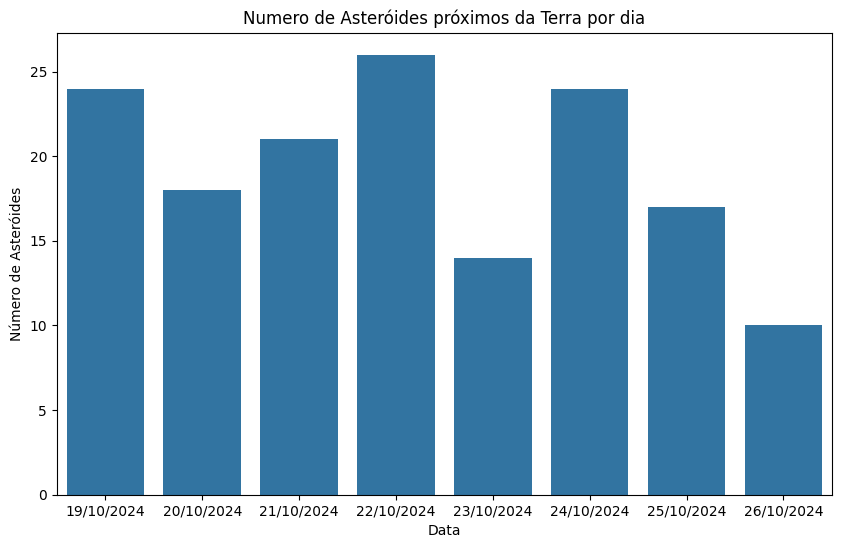

Os dados fornecidos indicam o número de asteroides próximos da Terra, variando ao longo de uma semana. Vemos que o número de asteroides flutua diariamente sem um padrão claro de crescimento ou diminuição. No dia com maior atividade (22/10/2024), foram observados 26 asteroides, enquanto no dia com a menor atividade (26/10/2024), apenas 10 foram registrados.

Essas flutuações podem ser resultado de vários fatores, incluindo a órbita dos asteroides em relação à Terra, a eficácia dos sistemas de detecção em uso e possíveis variações na atividade de objetos de menor tamanho, que são mais difíceis de rastrear. O fato de os números não seguirem um padrão consistente sugere que a presença de asteroides próximos da Terra pode ser bastante imprevisível em pequenas escalas de tempo, como dias ou semanas.

Além disso, é importante considerar que um aumento súbito no número de asteroides detectados em um dia específico pode indicar uma melhora ou mudança nas capacidades de detecção dos sistemas de 

In [223]:
asteroids_per_day = df_asteroids['close_approach_date'].value_counts().sort_index()
asteroids_per_day.index = asteroids_per_day.index.strftime('%d/%m/%Y')
plt.figure(figsize=(10,6))
sns.barplot(x=asteroids_per_day.index, y=asteroids_per_day.values)
plt.title('Numero de Asteróides próximos da Terra por dia')
plt.xlabel('Data')
plt.ylabel('Número de Asteróides')
plt.show()

prompt = f"Os dados a seguir mostram o número de asteroides próximos da Terra por dia: {asteroids_per_day.to_dict()}. Comente sobre o que esses dados podem indicar sobre a atividade de asteroides."
response_ai = get_ai_response(prompt)

print(response_ai['choices'][0]['message']['content'])

### Segunda Análise - Proporção de ateroides perigosos/não perigosos á Terra

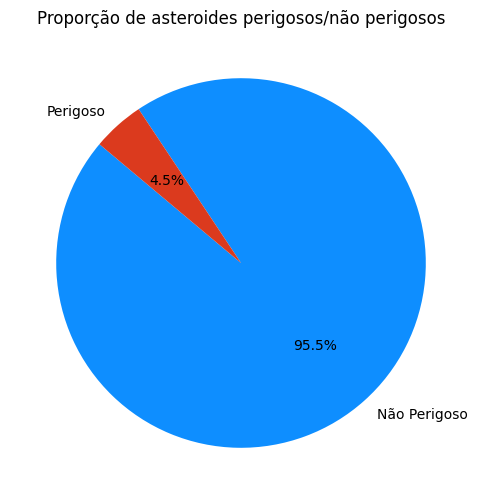

Os dados fornecidos indicam a quantidade de asteroides classificados como "perigosos" e "não perigosos". Especificamente, há 147 asteroides que foram considerados não perigosos (indicados por "False") e 7 considerados perigosos (indicados por "True").

Aqui estão algumas observações sobre esses dados:

1. **Proporção**: A proporção de asteroides perigosos em relação ao total é relativamente baixa. Com 7 asteroides perigosos em um total de 154 (147 não perigosos + 7 perigosos), os asteroides perigosos representam aproximadamente 4,55% do conjunto total.

2. **Interpretação**: Embora a quantidade de asteroides perigosos seja pequena em comparação aos não perigosos, ainda é importante monitorar os asteroides que são classificados como perigosos devido ao potencial impacto significativo que eles podem ter no caso de uma colisão com a Terra.

3. **Monitoramento e Gestão de Riscos**: Agências espaciais e organizações científicas ao redor do mundo se dedicam ao monitoramento contínuo desses o

In [224]:
plt.figure(figsize=(12, 6))
hazardous_count = df_asteroids['is_potentially_hazardous'].value_counts()
plt.pie(hazardous_count, labels=['Não Perigoso', 'Perigoso'], autopct='%1.1f%%', startangle=140, colors=['#0E8EFF', '#DB3A1E'])
plt.title('Proporção de asteroides perigosos/não perigosos')
plt.show()

prompt = f"Os dados a seguir mostram a proporção de asteroides perigosos e não perigosos: {hazardous_count.to_dict()}. Comente sobre."
response_ai = get_ai_response(prompt)

print(response_ai['choices'][0]['message']['content'])

### Terceira Análise - Visualizando correlação entre Menor distância e diâmetro máximo estimado

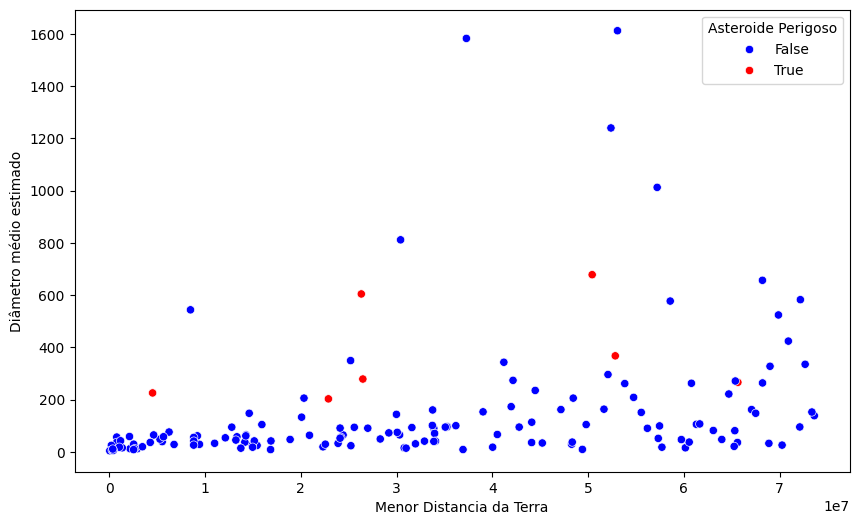


O que você pode comentar sobre {0: 524.25504307555, 1: 1240.3453329187, 2: 343.19631563445, 3: 51.7061994224, 4: 90.26982839495, 5: 81.94880347265, 6: 678.4886966075501, 7: 15.6150225901, 8: 29.21074388075, 9: 34.00498729, 10: 15.4007764483, 11: 143.72840855985, 12: 18.430733389300002, 13: 28.942938171100003, 14: 22.56018293205, 15: 20.89982342145, 16: 11.8070830178, 17: 12.2276392368, 18: 582.83096457445, 19: 261.5427084631, 20: 163.50935932570002, 21: 94.08981548444999, 22: 64.79516749595, 23: 162.01029650885, 24: 203.02177331975, 25: 24.7481430032, 26: 162.01029650885, 27: 90.68649499130001, 28: 9.53987352015, 29: 66.61048822570001, 30: 70.72005941205, 31: 147.75514650335, 32: 57.7487538173, 33: 100.35583224295, 34: 63.6125224068, 35: 15.6150225901, 36: 61.48123982475, 37: 23.54738132805, 38: 55.42971133025, 39: 56.72083516835, 40: 36.3197304625, 41: 76.05759995465, 42: 811.9749232641, 43: 1612.65926811645, 44: 656.9655806486501, 45: 64.79516749595, 46: 96.7258638057, 47: 105.57050

In [232]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='miss_distance_km', y='estimated_diameter_mean', hue='is_potentially_hazardous', 
                data=df_asteroids, palette={True: 'red', False: 'blue'})
plt.xlabel('Menor Distancia da Terra')
plt.ylabel('Diâmetro médio estimado')
plt.legend(title='Asteroide Perigoso')
plt.show()

prompt = f"""
O que você pode comentar sobre {df_asteroids['estimated_diameter_mean'].to_dict()} e {df_asteroids['miss_distance_km'].to_dict()} dado que sao valores de diametros medios estimados de um asteroide e a minima distancia de um asteroiude da Terra, respectivamente.
"""

response_ai = get_ai_response(prompt)
print(response_ai['choices'][0]['message']['content'])

### Quarta Análise - Visualizando a distribuição de diametro médio dos asteroides

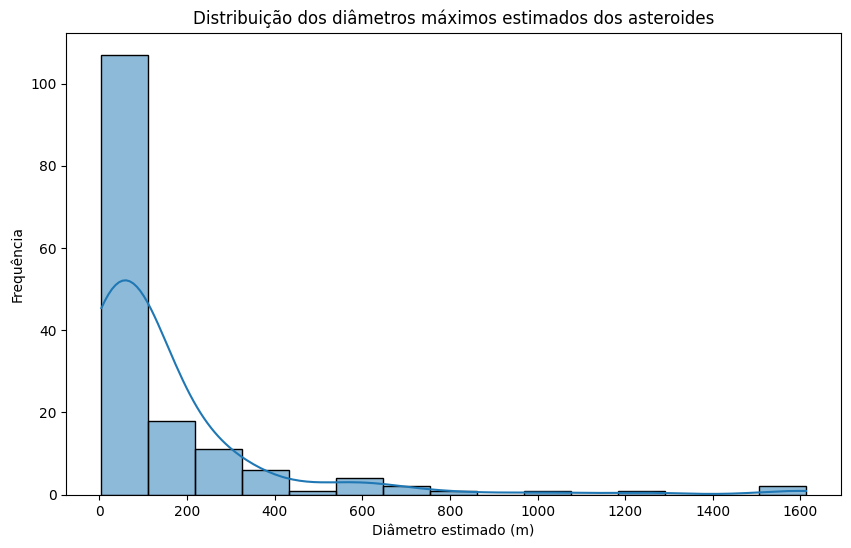

Para analisar a média e a distribuição das estimativas dos asteroides, podemos começar calculando a média dos valores fornecidos. Primeiro, encontraremos a soma total de todas as estimativas e depois dividiremos pelo número total de entradas.

Dado que há 154 valores no dicionário, podemos calcular a soma dos valores e a média:

Média \((M)\) = \(\frac{\text{Soma das estimativas}}{\text{Número de estimativas}}\)

Após calcular a soma dos valores listados, podemos obter a média.

Em termos de distribuição, podemos fazer algumas observações gerais com base nos valores:

1. **Amplitude dos Valores**: Os valores de estimativa variam bastante, desde pequenos números como 4.42 até valores acima de 1600. Isso indica uma grande variação no tamanho ou massa (ou qualquer outra métrica usada) dos asteroides estimados.

2. **Outliers**: Há alguns valores particularmente grandes, como 1612.65 e 1583.22, que são bem mais elevados do que a maioria dos demais valores, o que sugere a presença de outlie

In [227]:
plt.figure(figsize=(10, 6))
sns.histplot(df_asteroids['estimated_diameter_mean'], kde=True, bins=15)
plt.title('Distribuição dos diâmetros máximos estimados dos asteroides')
plt.xlabel('Diâmetro estimado (m)')
plt.ylabel('Frequência')
plt.show()



prompt = f"""
O que você pode comentar sobre a média das etimativas dos asteroides: {df_asteroids['estimated_diameter_mean'].to_dict()}. Comente sobre sua distribuição.
"""

response_ai = get_ai_response(prompt)

print(response_ai['choices'][0]['message']['content'])

### Quinta Análise - Vendo a distribuição das velocidades

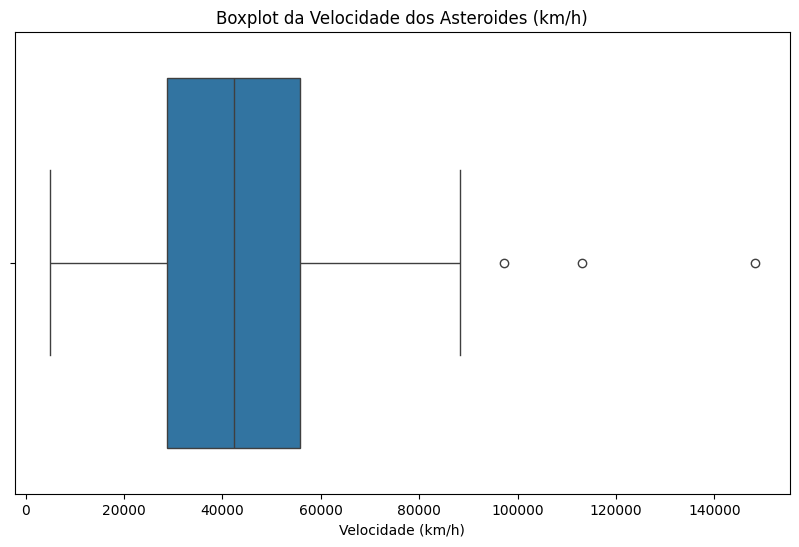


O que você pode comentar sobre a velocidade dos asteroides: {0: 148185.7480262956, 1: 82317.0440716297, 2: 53453.4606550249, 3: 68985.4822516714, 4: 27404.305513672, 5: 74909.9132592034, 6: 88016.8498259972, 7: 52922.0285262839, 8: 61281.7844413975, 9: 83176.9794516355, 10: 13866.1204636198, 11: 19185.8641613708, 12: 9628.6868565576, 13: 13299.4680502881, 14: 79121.1026008534, 15: 50765.0751298955, 16: 35086.460619923, 17: 34336.2365343529, 18: 84212.2420491658, 19: 72345.6249261415, 20: 85420.1319034781, 21: 49797.5210651016, 22: 9085.5097006719, 23: 97300.9531369829, 24: 44796.6985878284, 25: 27604.5694249583, 26: 55282.6410512958, 27: 63280.2107177172, 28: 23726.7971044044, 29: 53258.6550793867, 30: 29888.5279669648, 31: 49343.0117433426, 32: 29690.6685019133, 33: 33538.2126516345, 34: 42559.0656515161, 35: 55860.594653705, 36: 28060.8407210637, 37: 76826.0658759426, 38: 37320.1275197045, 39: 34321.1409072896, 40: 40856.4273479062, 41: 43952.2358796799, 42: 29795.9434701057, 43: 43

In [228]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='velocity_kmh', data=df_asteroids)
plt.title('Boxplot da Velocidade dos Asteroides (km/h)')
plt.xlabel('Velocidade (km/h)')
plt.show()

prompt = f"""
O que você pode comentar sobre a velocidade dos asteroides: {df_asteroids['velocity_kmh'].to_dict()}.
"""

response_ai = get_ai_response(prompt)

print(response_ai['choices'][0]['message']['content'])